# Formação de baseline com modelos estatísticos

## Introdução
OBS: Realizados alguns testes com outros estimadores, mas sem muito sucesso. **DESCARTADO**<br>

Utiliza o Scikit Learn para formação de baseline com algoritmos estatísticos afim de servir como parâmetro de comparação com outros modelos.

O dataset utilizado foi gerado a partir do notebook "Analise de boletins de jurisprudencia.ipynb" na pasta "eda" e contém os seguintes atributos:

|Campo             |Descrição                                                                                           |
|------------------|----------------------------------------------------------------------------------------------------|
|arquivo           |Arquivo de onde foi extraído o dado                                                                 |
|ano_mes           |Ano e mês   obtidos a partir do campo arquivo no formato AAAA-MM                                    |
|sumario           |Sumário do   boletim                                                                                |
|ementa            |Ementa da   decisão proferida                                                                       |
|informacoes       |Informações   do processo                                                                           |
|área_tematica     |Assunto da   decisão (variável alvo)                                                                |
|decisao_tipo      |Tipo da   decisão proferida                                                                         |
|decisao_numero    |Número da   decisão proferida                                                                       |
|decisao_ano       |Ano da   decisão proferida                                                                          |
|assunto_agrupado  |Resultado do agrupamento da coluna area_tematica durante processo de análise. (variável dependente) |

Cria modelos usando bag of words e TfIdf do sklearn

Criado po Antonio Filho em 04/10/2020 e atualizado em 28/10/2020<br>
Em 14/11/2020, alterado para considerar dataset que contém boletins de outubro de 2020.

## Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

import os
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import nlp_utils

from imblearn.over_sampling import SMOTE

## Carregar os dados

In [2]:
caminho_dados = Path("../../data/")
df = pd.read_csv(caminho_dados/"processed/tcepi_decisoes_ate_10_2020.csv", sep=";")

In [3]:
df.head()

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
0,Boletim de Jurisprudência TCE-PI - julho - 19....,2019-07,Responsabilidade. Desvio de finalidade. Não ex...,RECURSO DE RECONSIDERAÇÃO. TOMADA DE CONTAS. S...,(Recurso de Reconsideração. Processo – Relato...,RESPONSABILIDADE,acordao,1183,2019.0,RESPONSABILIDADE,9,0
1,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0
2,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Responsabilidade solidária d...,CONTROLE INTERNO DA PREFEITURA. SUBLOCAÇÃO DE ...,(Prestação de Contas. Processo – Relatora: Co...,RESPONSABILIDADE,acordao,1169,2020.0,RESPONSABILIDADE,9,0
3,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,0
4,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Não responsabilização do atu...,AUDITORIA DE OBRAS E SERVIÇOS DE ENGENHARIA. I...,(Auditoria. Processo – Relator: Conselheiro J...,RESPONSABILIDADE,acordao,506,2020.0,RESPONSABILIDADE,9,0


In [4]:
df.tail()

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
647,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,FUNDEB. Irregularidade na utilização do precat...,IRREGULARIDADES NA APLICAÇÃO DE PRECATÓRIOS DO...,(Representação. Processo 7 – Relator: Cons. Jo...,FUNDEB,acordao,582,2020.0,OUTROS,21,21
648,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Tributação. Isenções fiscais de ICMS sem a rea...,EMENTA. RENÚNCIA DE RECEITAS. GUERRA FISCAL. F...,(Prestação de Contas. Processo – Relator: Con...,TRIBUTACAO,acordao,3085,2017.0,OUTROS,22,22
649,Boletim de Jurisprudência TCE-PI - Junho - 18....,2018-06,Patrimônio. Inexistência de registros analític...,PRESTAÇÃO DE CONTAS. AUSÊNCIA DE REGISTRO PATR...,(Prestação de Contas. Processo – Relator: Con...,PATRIMONIO,acordao,840,2018.0,OUTROS,23,23
650,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2019-10,Representação. Prestação de contas em atraso c...,REPRESENTAÇÃO. PEDIDO DE BLOQUEIO DE CONTAS. P...,(Prestação de Contas. Processo 9 – Relator: Co...,REPRESENTACAO,acordao,1584,2019.0,OUTROS,24,24
651,Boletim de Jurisprudência TCE-PI - agosto 2020...,2020-08,Pagamento. Pagamentos em espécie superior ao l...,TOMADA DE CONTAS ESPECIAL. PAGAMENTOS EM ESPÉC...,(Tomada de Contas. Processo – Relator: Cons. ...,PAGAMENTO,acordao,736,2020.0,OUTROS,25,25


In [5]:
df.shape

(652, 12)

In [6]:
# Distribuição da variável dependente
pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual=df.assunto_agrupado.value_counts(normalize=True))\
        .rename(columns={'assunto_agrupado': 'qtde'})

,qtde,percentual
LICITACAO,122,0.187117
PESSOAL,118,0.180982
OUTROS,106,0.162577
DESPESA,65,0.099693
PROCESSUAL,62,0.095092
PRESTACAO DE CONTAS,46,0.070552
CONTRATO,43,0.065951
PREVIDENCIA,35,0.053681
AGENTE POLITICO,31,0.047546
RESPONSABILIDADE,24,0.036810


## Criar dataset para teste

In [7]:
def create_test_dataset(df: pd.DataFrame, percent: int) -> pd.DataFrame:
    df_freq = pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual=df.assunto_agrupado.value_counts(normalize=True))\
        .rename(columns={'assunto_agrupado': 'qtde'})

    df_test = df.copy()[0:0]
    for index, row in df_freq.iterrows(): 
        df_test = df_test.append(df[df.assunto_agrupado==index].sample(int((row["qtde"])*(percent/100))))
    
    return df_test

In [8]:
df_test = create_test_dataset(df, 15)
df_test

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
501,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Licitação. Atraso no cadastramento de processo...,CONTAS DE GESTÃO DA PREFEITURA. FALHA DO CONTR...,(Prestação de Contas. Processo – Relatora: Co...,LICITACAO,acordao,1027,2020.0,LICITACAO,1,8
444,Boletim de Jurisprudência TCE-PI - Março - 19....,2019-03,Licitação. Obrigação de solicitação de parecer...,PROCESSUAL. LICITAÇÃO. REGULARIDADE COM RESSAL...,(Prestação de Contas. Processo 6 – Relator: Co...,LICITACAO,acordao,430,2019.0,LICITACAO,1,8
521,Boletim de Jurisprudência TCE-PI -MARÇO 2020.docx,2020-03,Licitação. Inexigibilidade de licitação. Preço...,ATOS DE GESTÃO. PAGAMENTO DE PRESTADOR DE SERV...,(Prestação de Contas. Processo – Relator: Con...,LICITACAO,acordao,159,2020.0,LICITACAO,1,8
469,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Licitação. Alterações no edital quanto à quant...,EMENTA: LICITAÇÃO. ALTERAÇÃO DE EDITAL. ERRO M...,(Agravo Regimental. Processo – Relator: Cons....,LICITACAO,acordao,3026,2017.0,LICITACAO,1,8
437,Boletim de Jurisprudência TCE-PI - Abril - 19....,2019-04,Licitação. Afronta aos princípios da impessoal...,EMENTA. PROCESSUAL. LICITAÇÃO. IRREGULARIDADE....,(Denúncia. Processo – Relator: Cons. Substitu...,LICITACAO,acordao,1785,2018.0,LICITACAO,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
25,Boletim de Jurisprudência TCE-PI - Outubro 202...,2020-10,Agente Político. Variação do subsídio dos vere...,CONTAS DA CÂMARA MUNICIPAL. INADEQUAÇÃO DO POR...,(Prestação de Contas. Processo – Relatora: Co...,AGENTE POLITICO,acordao,1394,2020.0,AGENTE POLITICO,8,1
50,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Agente Político. Fixação dos subsídios dos ver...,FIXAÇÃO DOS SUBSÍDIOS DOS VEREADORES APROVADA ...,(Prestação de Contas. Processo 7 – Relator: Lu...,AGENTE POLITICO,acordao,599,2020.0,AGENTE POLITICO,8,1
23,Boletim de Jurisprudência TCE-PI - Abril - 19....,2019-04,Responsabilidade. Papel do gestor como guardiã...,REPRESENTAÇÃO. CONTRATAÇÃO DE EMPRESA PROIBIDA...,(Representação. Processo – Relator: Cons. Kle...,RESPONSABILIDADE,acordao,598,2019.0,RESPONSABILIDADE,9,0
2,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Responsabilidade solidária d...,CONTROLE INTERNO DA PREFEITURA. SUBLOCAÇÃO DE ...,(Prestação de Contas. Processo – Relatora: Co...,RESPONSABILIDADE,acordao,1169,2020.0,RESPONSABILIDADE,9,0


In [9]:
# Distribuição da variável dependente no dataset de teste
df_comp = pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual_total=df.assunto_agrupado.value_counts(normalize=True)*100)\
        .assign(qtde_teste=df_test.assunto_agrupado.value_counts())\
        .assign(percentual_teste=df_test.assunto_agrupado.value_counts(normalize=True)*100)\
        .rename(columns={'assunto_agrupado': 'qtde_total'})
df_comp['percentual_dif'] = df_comp['percentual_teste']-df_comp['percentual_total']
df_comp

,qtde_total,percentual_total,qtde_teste,percentual_teste,percentual_dif
LICITACAO,122,18.711656,18,19.565217,0.853561
PESSOAL,118,18.098160,17,18.478261,0.380101
OUTROS,106,16.257669,15,16.304348,0.046679
DESPESA,65,9.969325,9,9.782609,-0.186716
PROCESSUAL,62,9.509202,9,9.782609,0.273406
PRESTACAO DE CONTAS,46,7.055215,6,6.521739,-0.533476
CONTRATO,43,6.595092,6,6.521739,-0.073353
PREVIDENCIA,35,5.368098,5,5.434783,0.066684
AGENTE POLITICO,31,4.754601,4,4.347826,-0.406775
RESPONSABILIDADE,24,3.680982,3,3.260870,-0.420112


### Removar do dataset geral os registros inseridos no dataset de teste

In [10]:
df_model = df[df.index.isin(df_test.index.tolist()) == False]
df_model

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
1,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0
3,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,0
4,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Não responsabilização do atu...,AUDITORIA DE OBRAS E SERVIÇOS DE ENGENHARIA. I...,(Auditoria. Processo – Relator: Conselheiro J...,RESPONSABILIDADE,acordao,506,2020.0,RESPONSABILIDADE,9,0
5,Boletim de Jurisprudência TCE-PI - julho 2020 ...,2020-07,Responsabilidade. O gestor público ou qualquer...,TOMADA DE CONTAS ESPECIAL. SECRETARIA DE CULTU...,(Prestação de Contas. Processo – Relatora: Co...,RESPONSABILIDADE,acordao,882,2020.0,RESPONSABILIDADE,9,0
6,Boletim de Jurisprudência TCE-PI - julho 2020 ...,2020-07,Responsabilidade. Compete ao gestor comprovar ...,NÃO ENVIO DOS DADOS DO SAGRES FOLHA – 13º SALÁ...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,890,2020.0,RESPONSABILIDADE,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
647,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,FUNDEB. Irregularidade na utilização do precat...,IRREGULARIDADES NA APLICAÇÃO DE PRECATÓRIOS DO...,(Representação. Processo 7 – Relator: Cons. Jo...,FUNDEB,acordao,582,2020.0,OUTROS,21,21
648,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Tributação. Isenções fiscais de ICMS sem a rea...,EMENTA. RENÚNCIA DE RECEITAS. GUERRA FISCAL. F...,(Prestação de Contas. Processo – Relator: Con...,TRIBUTACAO,acordao,3085,2017.0,OUTROS,22,22
649,Boletim de Jurisprudência TCE-PI - Junho - 18....,2018-06,Patrimônio. Inexistência de registros analític...,PRESTAÇÃO DE CONTAS. AUSÊNCIA DE REGISTRO PATR...,(Prestação de Contas. Processo – Relator: Con...,PATRIMONIO,acordao,840,2018.0,OUTROS,23,23
650,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2019-10,Representação. Prestação de contas em atraso c...,REPRESENTAÇÃO. PEDIDO DE BLOQUEIO DE CONTAS. P...,(Prestação de Contas. Processo 9 – Relator: Co...,REPRESENTACAO,acordao,1584,2019.0,OUTROS,24,24


### Salvar datasetes para teste e para modelagem (treino e validação)

In [11]:
# Dataset de teste
df_test.to_csv(Path("../../data/processed/tcepi_decisoes_10_20_test.csv"), index=False, sep=';')

# Dataset para uso na modelagem
df_model.to_csv(Path("../../data/processed/tcepi_decisoes_10_20_train.csv"), index=False, sep=';')

## Importar bibliotecas do Scikit Learn

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV  # Busca os melhores parâmetros para o treinamento
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, classification_report, accuracy_score, \
    plot_confusion_matrix, precision_score, recall_score

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from joblib import dump, load

from nltk import FreqDist, word_tokenize

from wordcloud import WordCloud

from pprint import pprint
from time import time
import logging

print(__doc__)
# Display progress logs on stdout (Ajuda a entender em que ponto está a execução. Útl para as combinações feitas pelo GridAearch)
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


## Criar modelo para predição de classes

### Baseline: modelo baseado na variável Ementa sem pré-processamento

In [13]:
del df

In [14]:
caminho_dados = Path("../../data/")
df_model = pd.read_csv(caminho_dados/"processed/tcepi_decisoes_10_20_train.csv", sep=";")

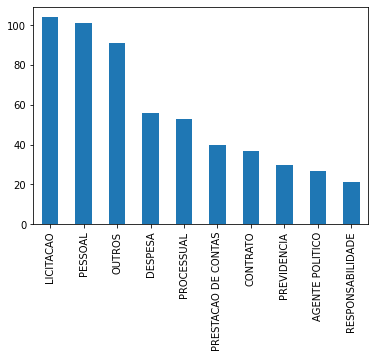

In [15]:
df_model.assunto_agrupado.value_counts().plot(kind='bar')

In [16]:
# Usar comando stratify para garantir que o percentual das classe  permaneça nos 2 conjuntos
X_train, X_test, y_train, y_test = \
    train_test_split(df_model.ementa, df_model.assunto_agrupado, test_size=0.2, \
                     stratify=df_model.assunto_agrupado, random_state=42)

In [17]:
X_train[:10]

26     DESPESA. VARIAÇÃO DE SUBSÍDIO DE VEREADORES SE...
129    PARECER PRÉVIO. ATRASO NO ENVIO DAS PEÇAS ORÇA...
12     PRESTAÇÃO DE CONTAS. PREFEITURA MUNICIPAL DE S...
97     EMENTA: PRESTAÇÃO DE CONTAS. LICITAÇÃO. PERMIS...
440    TOMADA DE CONTAS ESPECIAL. IMPLANTAÇÃO DE ESTR...
450    PRESTAÇÃO DE CONTAS. ATRASO. LICITAÇÃO. IRREGU...
11     RECURSO DE RECONSIDERAÇÃO PRESTAÇÃO DE CONTAS ...
424    ANÁLISE DE PRESTAÇÃO DE CONTAS. IRREGULARIDADE...
237    CONTAS ANUAIS DE GOVERNO. DESCUMPRIMENTO DO LI...
171    EMENTA: PESSOAL. EXONERAÇÃO DE CONTROLADORA IN...
Name: ementa, dtype: object

In [18]:
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (448,) 
 LICITACAO              0.185268
PESSOAL                0.180804
OUTROS                 0.162946
DESPESA                0.100446
PROCESSUAL             0.093750
PRESTACAO DE CONTAS    0.071429
CONTRATO               0.066964
PREVIDENCIA            0.053571
AGENTE POLITICO        0.046875
RESPONSABILIDADE       0.037946
Name: assunto_agrupado, dtype: float64 

TESTE  :  (112,) 
 LICITACAO              0.187500
PESSOAL                0.178571
OUTROS                 0.160714
DESPESA                0.098214
PROCESSUAL             0.098214
PRESTACAO DE CONTAS    0.071429
CONTRATO               0.062500
AGENTE POLITICO        0.053571
PREVIDENCIA            0.053571
RESPONSABILIDADE       0.035714
Name: assunto_agrupado, dtype: float64


In [19]:
text_train = list(X_train)
text_test = list(X_test)
text_train[:5]

['DESPESA. VARIAÇÃO DE SUBSÍDIO DE VEREADORES SEM DISPONIBILIDADE FINANCEIRA. IRREGULARIDADE. \nA fixação de subsídio de vereadores sem a correspondente disponibilidade financeira por parte do Legislativo constitui burla ao art. 29, inciso VI da Constituição Federal.',
 'PARECER PRÉVIO. ATRASO NO ENVIO DAS PEÇAS ORÇAMENTÁRIAS – PPA E LOA.\nRejeitados os dados ou as informações, o reenvio das peças orçamentárias rejeitadas será admitido uma única vez, nos termos do parágrafo único do art. 47 da Resolução TCE n° 39/2015.',
 'PRESTAÇÃO DE CONTAS. PREFEITURA MUNICIPAL DE SIMPLÍCIO MENDES. CONTAS DE GOVERNO. EXERCÍCIO 2015. ATRASO NA ENTREGA DAS PRESTAÇÕES DE CONTAS MENSAIS. PEÇAS AUSENTES EXIGIDAS PELA RESOLUÇÃO TCE Nº 09/2014. ATRASO NA ENTREGA DA PRESTAÇÃO DE CONTAS ANUAL. DESCUMPRIMENTO DO LIMITE MÍNIMO CONSTITUCIONAL COM DESPESA COM MANUTENÇÃO E DESENVOLVIMENTO DE ENSINO. BALANÇO FINANCEIRO INCOMPLETO. DIVERGÊNCIA NO DEMONSTRATIVO DA DÍVIDA FLUTUANTE.\n1. o envio apenas em sede de Defe

In [20]:
target_train = list(y_train)
target_test = list(y_test)
print(target_test[:5])

['RESPONSABILIDADE', 'OUTROS', 'PROCESSUAL', 'DESPESA', 'DESPESA']


In [21]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=3, loss='log')), # default hinge. to get proba=log or modified_huber
])

In [23]:
parameters = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    #'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__max_iter': (20, 100),
}

In [24]:
def modelo(X, y, pipeline, parameters):
    # find the best parameters for both the feature extraction and the classifier
    # n_jobs=-1 -> Usar todas as CPUs diponíveis 
    # verbose=1 -> Exibir o que está fazendo
    # cv=5      -> Cross validation em 5 partes
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return grid_search

#### Treinamento do modelo
Usando o algoritmo SGDClassifier instanciado no pipeline

In [25]:
gs_sgd_10_outros = modelo(X_train, y_train, pipeline, parameters)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   24.3s finished


done in 24.650s

Best score: 0.661
Best parameters set:
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)


#### Analisando predições do modelo

In [26]:
gs_sgd_10_outros.best_estimator_.predict(text_test)

array(['PROCESSUAL', 'OUTROS', 'PESSOAL', 'LICITACAO', 'AGENTE POLITICO',
       'LICITACAO', 'OUTROS', 'LICITACAO', 'PESSOAL', 'OUTROS',
       'PRESTACAO DE CONTAS', 'OUTROS', 'OUTROS', 'PESSOAL', 'OUTROS',
       'DESPESA', 'LICITACAO', 'PESSOAL', 'LICITACAO', 'PESSOAL',
       'DESPESA', 'PESSOAL', 'AGENTE POLITICO', 'PESSOAL', 'OUTROS',
       'OUTROS', 'LICITACAO', 'OUTROS', 'LICITACAO', 'OUTROS',
       'PROCESSUAL', 'PRESTACAO DE CONTAS', 'PRESTACAO DE CONTAS',
       'LICITACAO', 'AGENTE POLITICO', 'PREVIDENCIA', 'PESSOAL',
       'LICITACAO', 'LICITACAO', 'OUTROS', 'PRESTACAO DE CONTAS',
       'PREVIDENCIA', 'OUTROS', 'LICITACAO', 'LICITACAO', 'OUTROS',
       'OUTROS', 'OUTROS', 'LICITACAO', 'OUTROS', 'PESSOAL', 'OUTROS',
       'PESSOAL', 'PESSOAL', 'PRESTACAO DE CONTAS', 'LICITACAO',
       'AGENTE POLITICO', 'OUTROS', 'AGENTE POLITICO', 'PESSOAL',
       'PROCESSUAL', 'OUTROS', 'PESSOAL', 'PESSOAL', 'OUTROS', 'DESPESA',
       'LICITACAO', 'OUTROS', 'OUTROS', 'AGENTE POL

In [27]:
prob_preds= gs_sgd_10_outros.best_estimator_.predict_proba(text_test)
prob_preds[:10]

array([[0.01366883, 0.06400766, 0.0381097 , 0.08237195, 0.02870369,
        0.02690617, 0.03275231, 0.02050519, 0.67529834, 0.01767616],
       [0.00778981, 0.04674663, 0.25651914, 0.01752782, 0.49730689,
        0.02504044, 0.02398955, 0.01812794, 0.08105262, 0.02589915],
       [0.00431466, 0.02017767, 0.02753298, 0.00993378, 0.00806751,
        0.88564856, 0.01078168, 0.01081663, 0.01495111, 0.00777543],
       [0.01294588, 0.09654799, 0.02928069, 0.51838837, 0.00916625,
        0.11304843, 0.02171254, 0.02317469, 0.15841361, 0.01732156],
       [0.40725031, 0.0778125 , 0.03538949, 0.04208375, 0.08077095,
        0.1347791 , 0.02292502, 0.02861168, 0.12485542, 0.04552179],
       [0.00936099, 0.03156507, 0.04065369, 0.67652161, 0.11271342,
        0.02460889, 0.0262426 , 0.02174442, 0.03348205, 0.02310727],
       [0.01296661, 0.05314518, 0.21284847, 0.02120392, 0.31049552,
        0.29490662, 0.02977178, 0.03893852, 0.00368833, 0.02203503],
       [0.0087327 , 0.03957126, 0.0531016

In [28]:
print(np.argmax(prob_preds[0]))
print(np.max(prob_preds[0]))
prob_preds[0]

8
0.6752983412356457


array([0.01366883, 0.06400766, 0.0381097 , 0.08237195, 0.02870369,
       0.02690617, 0.03275231, 0.02050519, 0.67529834, 0.01767616])

In [29]:
np.argsort(prob_preds[0])[::-1][:3]

array([8, 3, 1], dtype=int64)

In [30]:
np.sort(prob_preds[0])[::-1][:3]

array([0.67529834, 0.08237195, 0.06400766])

In [31]:
#np.argmax(prob_preds, axis=1)
#np.sort(prob_preds, axis=1)[:,-2:-1]
np.sort(prob_preds, axis=1)[:,-3:-2]

array([[0.06400766],
       [0.08105262],
       [0.02017767],
       [0.11304843],
       [0.12485542],
       [0.04065369],
       [0.21284847],
       [0.05310168],
       [0.05653919],
       [0.06397205],
       [0.06408403],
       [0.11111448],
       [0.13606845],
       [0.0725545 ],
       [0.14915589],
       [0.14388424],
       [0.05192618],
       [0.01270417],
       [0.02486187],
       [0.05691699],
       [0.1103723 ],
       [0.04665628],
       [0.07245551],
       [0.01006421],
       [0.05751455],
       [0.15844162],
       [0.09393181],
       [0.04260468],
       [0.0527156 ],
       [0.1311292 ],
       [0.02523154],
       [0.09253473],
       [0.10277582],
       [0.03417011],
       [0.02862078],
       [0.04268652],
       [0.02575497],
       [0.02014135],
       [0.0119932 ],
       [0.03593311],
       [0.05009432],
       [0.01996323],
       [0.12958436],
       [0.0350091 ],
       [0.03191259],
       [0.15126187],
       [0.06780571],
       [0.148

In [32]:
df_proba = pd.DataFrame(columns=['texto','assunto', 'predicted', 'probabilidade','pred_2','prob_2','pred_3','prob_3'])
df_proba['texto'] = text_test
df_proba['assunto'] = target_test
df_proba['predicted'] = gs_sgd_10_outros.best_estimator_.predict(text_test)
df_proba['probabilidade'] = np.max(prob_preds, axis=1).tolist()
df_proba['pred_2'] = np.argsort(prob_preds, axis=1)[:,-2:-1].tolist()
df_proba['prob_2'] = np.sort(prob_preds, axis=1)[:,-2:-1].tolist()
df_proba['pred_3'] = np.argsort(prob_preds, axis=1)[:,-3:-2].tolist()
df_proba['prob_3'] = np.sort(prob_preds, axis=1)[:,-3:-2].tolist()

#df_proba['prob_2'] = df_proba['prob_2'].astype(float)

In [33]:
print(df_proba.shape)
df_proba.head()

(112, 8)


,texto,assunto,predicted,probabilidade,pred_2,prob_2,pred_3,prob_3
0,DENÚNCIA. DESCUMPRIMENTO A DETERMINAÇÃO DO TRI...,RESPONSABILIDADE,PROCESSUAL,0.675298,[3],[0.08237194510063514],[1],[0.0640076628871002]
1,IRREGULARIDADE NA UTILIZAÇÃO DE RECURSOS DO FU...,OUTROS,OUTROS,0.497307,[2],[0.2565191398269901],[8],[0.08105261901477961]
2,PESSOAL. APOSENTADORIA. \n1. As situações flag...,PROCESSUAL,PESSOAL,0.885649,[2],[0.027532983989159304],[1],[0.0201776662686886]
3,SUPOSTAS IRREGULARIDADES EM OPERAÇÃO DE CRÉDIT...,DESPESA,LICITACAO,0.518388,[8],[0.15841361037014104],[5],[0.11304842946080955]
4,PROCESSUAL. FIXAÇÃO DE SUBSÍDIO DO PREFEITO E ...,DESPESA,AGENTE POLITICO,0.407250,[5],[0.13477910035571805],[8],[0.12485542309892822]


In [34]:
gs_sgd_10_outros.best_estimator_.predict(text_test) == target_test

array([False,  True, False, False, False,  True, False,  True,  True,
       False,  True, False,  True, False, False,  True, False,  True,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [35]:
print('Score: ', gs_sgd_10_outros.best_estimator_.score(text_test, target_test))
                
# Avaliar o f1-Score, métrica mais indicada em função dos desbalanceamento das classes
f1_score_val = f1_score(y_test, gs_sgd_10_outros.best_estimator_.predict(X_test), average="weighted")                                                
print(f'F1-Score: {f1_score_val}')
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, gs_sgd_10_outros.best_estimator_.predict(X_test))))
#print("AUC: {:.4f}\n".format(roc_auc_score(y_test, gs_sgd_10_outros.best_estimator_.predict(X_test), multi_class='ovr')))
print("Relatório de Classificação:\n", classification_report(y_test, gs_sgd_10_outros.best_estimator_.predict(X_test), digits=4))                                          

Score:  0.6607142857142857
F1-Score: 0.6243628665199156
Acurácia: 0.6607

Relatório de Classificação:
                      precision    recall  f1-score   support

    AGENTE POLITICO     0.5556    0.8333    0.6667         6
           CONTRATO     1.0000    0.1429    0.2500         7
            DESPESA     0.5000    0.2727    0.3529        11
          LICITACAO     0.7917    0.9048    0.8444        21
             OUTROS     0.5172    0.8333    0.6383        18
            PESSOAL     0.7083    0.8500    0.7727        20
PRESTACAO DE CONTAS     0.6667    0.5000    0.5714         8
        PREVIDENCIA     0.6667    0.3333    0.4444         6
         PROCESSUAL     0.8000    0.7273    0.7619        11
   RESPONSABILIDADE     0.0000    0.0000    0.0000         4

           accuracy                         0.6607       112
          macro avg     0.6206    0.5398    0.5303       112
       weighted avg     0.6613    0.6607    0.6244       112



C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Verificar resultado em dataset de teste

In [36]:
# Inverter(em relação ao teste anterir) o uso de listas e as varáveis do train_test_split
print("Relatório de Classificação:\n", \
      classification_report(df_test.assunto_agrupado, gs_sgd_10_outros.best_estimator_.predict(df_test.ementa), digits=4))                                          

Relatório de Classificação:
                      precision    recall  f1-score   support

    AGENTE POLITICO     0.7500    0.7500    0.7500         4
           CONTRATO     0.4545    0.8333    0.5882         6
            DESPESA     0.5000    0.2222    0.3077         9
          LICITACAO     0.7368    0.7778    0.7568        18
             OUTROS     0.5000    0.4667    0.4828        15
            PESSOAL     0.7619    0.9412    0.8421        17
PRESTACAO DE CONTAS     0.6667    0.6667    0.6667         6
        PREVIDENCIA     0.7500    0.6000    0.6667         5
         PROCESSUAL     0.8750    0.7778    0.8235         9
   RESPONSABILIDADE     0.0000    0.0000    0.0000         3

           accuracy                         0.6630        92
          macro avg     0.5995    0.6036    0.5884        92
       weighted avg     0.6475    0.6630    0.6437        92



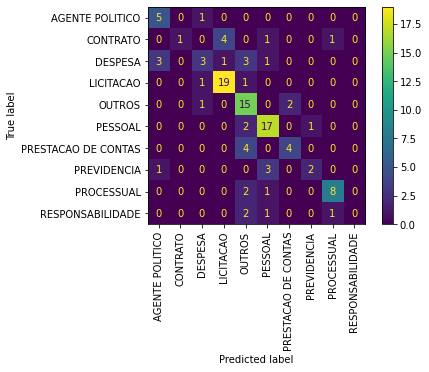

In [40]:
plot_confusion_matrix(gs_sgd_10_outros.best_estimator_, X_test, y_test, xticks_rotation='vertical')

#### Salvar o modelo para posterior reuso

In [41]:
caminho_model = Path("../../model/")
dump(gs_sgd_10_outros.best_estimator_, caminho_model/'modelo_SGD_9_classes_mais_outros.pkl')

['..\\..\\model\\modelo_SGD_9_classes_mais_outros.pkl']

### Testar  desempenho apenas das 4 principais classe e o resto agrupado em OUTROS

In [42]:
count_clf_assuntos = pd.DataFrame(df_model.groupby('assunto_agrupado')['arquivo']\
                              .count()\
                              .sort_values(ascending=False)\
                              .copy())\
                              .rename(columns={'arquivo' : 'quantitativo'})
count_clf_assuntos = count_clf_assuntos.assign(
    soma_acumulada=count_clf_assuntos.quantitativo.cumsum())
count_clf_assuntos = count_clf_assuntos.assign(
    perc_acumulado= 100*count_clf_assuntos.soma_acumulada/count_clf_assuntos.quantitativo.sum(),
    rank=range(1, count_clf_assuntos.shape[0]+1)
)
count_clf_assuntos['rank'] = count_clf_assuntos['rank'].astype('category')
count_clf_assuntos.reset_index(inplace=True)
count_clf_assuntos

,assunto_agrupado,quantitativo,soma_acumulada,perc_acumulado,rank
0,LICITACAO,104,104,18.571429,1
1,PESSOAL,101,205,36.607143,2
2,OUTROS,91,296,52.857143,3
3,DESPESA,56,352,62.857143,4
4,PROCESSUAL,53,405,72.321429,5
5,PRESTACAO DE CONTAS,40,445,79.464286,6
6,CONTRATO,37,482,86.071429,7
7,PREVIDENCIA,30,512,91.428571,8
8,AGENTE POLITICO,27,539,96.250000,9
9,RESPONSABILIDADE,21,560,100.000000,10


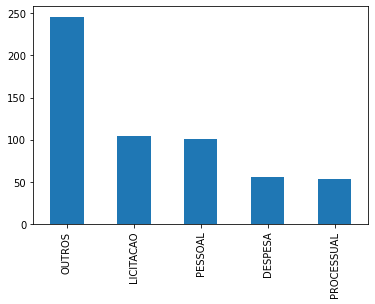

In [43]:
Y = df_model.area_tematica.apply(lambda x: x if x in count_clf_assuntos[:5]['assunto_agrupado'].to_list() else 'OUTROS')
Y.value_counts().plot(kind='bar')

In [51]:
# Função para excutar criação do modelo e validar resultados
def model_test(X_train, X_test, y_train, y_test, pipeline, parameters):

    grid_search = modelo(X_train, y_train, pipeline, parameters)

    print('Score: ', grid_search.best_estimator_.score(X_test, y_test))
    print('F1-Score: ', f1_score(y_test, grid_search.best_estimator_.predict(X_test), average="weighted"))
    

    plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test, xticks_rotation='vertical')
    
    return grid_search

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   19.5s finished


done in 19.752s

Best score: 0.723
Best parameters set:
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
Score:  0.7410714285714286
F1-Score:  0.693849137405038


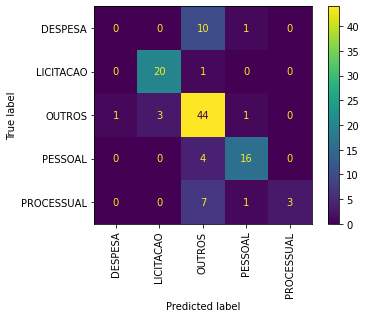

In [52]:
X_train_b, X_test_b, y_train_b, y_test_b = \
    train_test_split(df_model.ementa, Y, test_size=0.2, stratify=Y, random_state=42)
gs_sgd_4_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipeline, parameters)

#### Salvar o modelo para posterior reuso

In [46]:
caminho_model = Path("../../model/")
dump(gs_sgd_4_outros.best_estimator_, caminho_model/'modelo_SGD_4_classes_mais_outros.pkl')

['..\\..\\model\\modelo_SGD_4_classes_mais_outros.pkl']

### Testar descartando OUTROS e mantendo as 9 classes usadas anteriormente

In [53]:
df1 = df_model.copy()

In [54]:
df1.assunto_agrupado.value_counts()

LICITACAO              104
PESSOAL                101
OUTROS                  91
DESPESA                 56
PROCESSUAL              53
PRESTACAO DE CONTAS     40
CONTRATO                37
PREVIDENCIA             30
AGENTE POLITICO         27
RESPONSABILIDADE        21
Name: assunto_agrupado, dtype: int64

In [55]:
df1 = df1[df1.assunto_agrupado!='OUTROS']
df1.assunto_agrupado.value_counts()

LICITACAO              104
PESSOAL                101
DESPESA                 56
PROCESSUAL              53
PRESTACAO DE CONTAS     40
CONTRATO                37
PREVIDENCIA             30
AGENTE POLITICO         27
RESPONSABILIDADE        21
Name: assunto_agrupado, dtype: int64

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   22.3s finished


done in 22.766s

Best score: 0.683
Best parameters set:
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
Score:  0.6914893617021277
F1-Score:  0.656713015767383


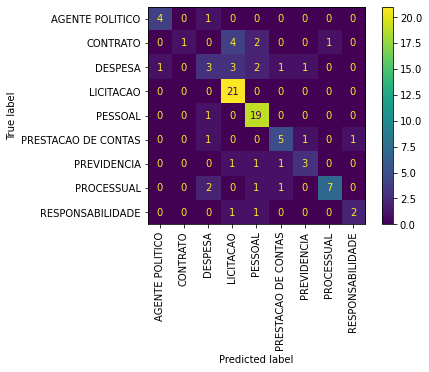

In [56]:
X_train_b, X_test_b, y_train_b, y_test_b = \
    train_test_split(df1.ementa, df1.assunto_agrupado, test_size=0.2, stratify=df1.assunto_agrupado, random_state=42)
gs_sgd_10_sem_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipeline, parameters)

#### Salvar o modelo para posterior reuso

In [77]:
caminho_model = Path("../../model/")
dump(gs_sgd_10_sem_outros.best_estimator_, caminho_model/'modelo_SGD_10_classes_sem_outros.pkl')

['..\\..\\model\\modelo_SGD_10_classes_sem_outros.pkl']

### Resultado do baseline para SGDClassifier sem normalização

| Algoritmo     | Nº Classes | OUTROS? | Normalização | Score  | F1-Score |
|---------------|-----------:|:-------:|:------------:|--------|----------|
| SGDClassifier |          9 |   Sim   |      Não     | 66,07% | 62,43%   |
| SGDClassifier |          4 |   Sim   |      Não     | 74,10% | 69,38%   |
| SGDClassifier |          9 |   Não   |      Não     | 69,14% | 65,67%   |

Com base nesse resultado, vou concentrar testes usando as 9 principais classe e OUTROS. Apesar de resultado ser pior, terá mais utilidade para o negócio. Objetivo agora será verificar desempenho com normalização e com outros algoritmos

### Normalização

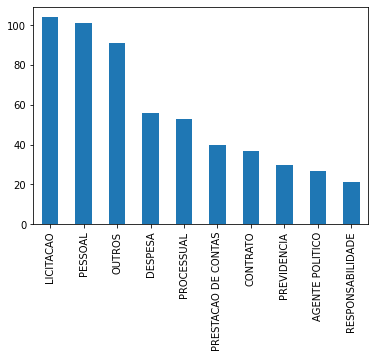

In [57]:
# Verificar se o agrupamento de assuntos está correto
df_model.assunto_agrupado.value_counts().plot(kind='bar')

In [58]:
# Fonte: https://github.com/netoferraz/o-eu-analitico/blob/master/_notebooks/2020-07-26-gov-data-product-p3.ipynb
def make_word_cloud(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        print(len(stopwords))
        wordcloud = WordCloud(width=1024, height=768, stopwords=stopwords, margin=0).generate(corpus_normativos)
    else:
        wordcloud = WordCloud(width=1024, height=768, margin=0).generate(corpus_normativos)
    #show
    plt.figure(figsize=[15, 9])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

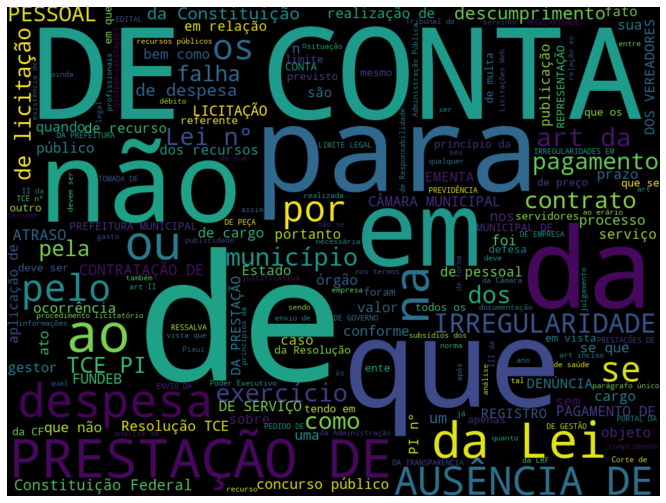

In [59]:
# Word cloud antes de normalização
make_word_cloud(df_model.ementa)

In [60]:
def frequency_plot(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        tokenize_corpus = [w for w in tokenize_corpus if w not in stopwords]
    plt.figure(figsize=(10,5))
    fd = FreqDist(tokenize_corpus)
    fd.plot(30,title = "Palavras x Frequência",cumulative=False)

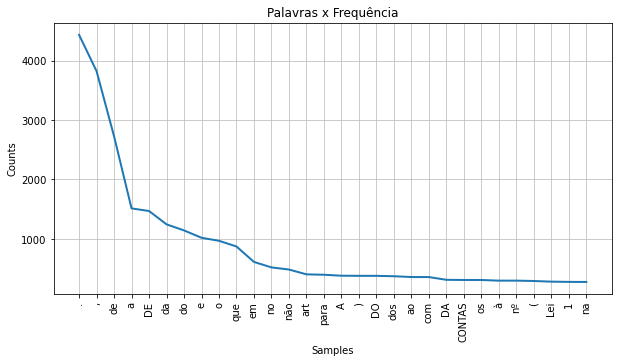

In [61]:
# Distribuição de frequência de palavras antes da normalização
frequency_plot(df_model.ementa)

In [62]:
#nlp_utils.pre_processing_pipeline(df.ementa)
df_model['ementa_limpa'] = df_model.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
df_model.head(2)

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade,ementa_limpa
0,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0,responsabilidade contratos firmados anteriores...
1,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,0,prestacao contas despesas com multas juros pel...


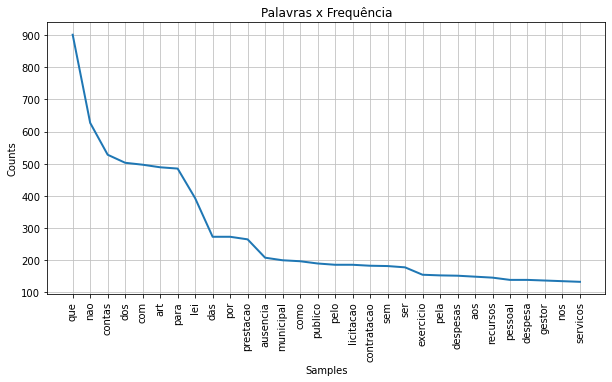

In [63]:
frequency_plot(df_model.ementa_limpa)

204


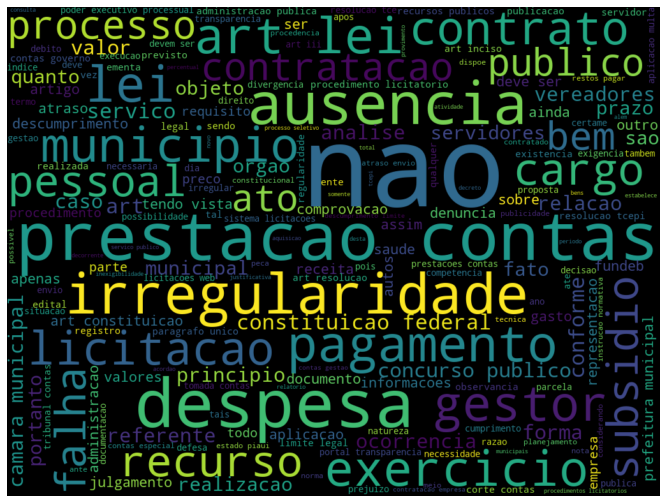

In [64]:
#remoção de stop words
from nltk.corpus import stopwords
stopwords_pt = stopwords.words('portuguese')
make_word_cloud(df_model.ementa_limpa, stopwords=stopwords_pt)

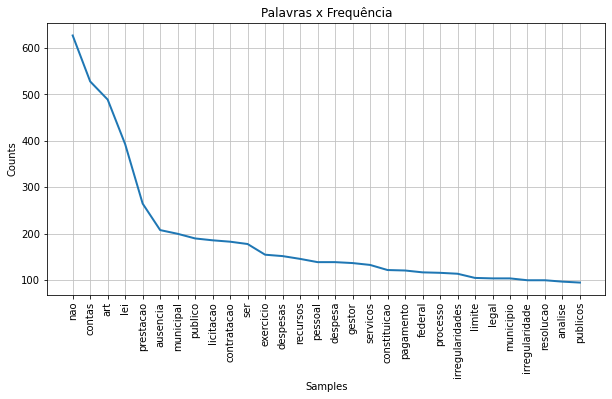

In [65]:
frequency_plot(df_model.ementa_limpa, stopwords=stopwords_pt)

### Novo modelo com texto normalizado e sem stopwords

In [66]:
param_sgd = {
    #'vect__max_df': (0.75, 1.0),
    #
    #'vect__max_features': (None, 5000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #
    'clf__alpha': (1e-6, 1e-3, 1e-1, 1e0),
    'clf__penalty': ('l2', 'l1'),
    'clf__max_iter': (5, 1000, 10000),
    'clf__tol': (None, 1e-3),
    'clf__eta0': (0.1, 0.001)
}

pipe_norm = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt, ngram_range=(1, 2), min_df = 2, max_df = .95)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42, loss='log'))
])

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-06, 0.001, 0.1, 1.0),
 'clf__eta0': (0.1, 0.001),
 'clf__max_iter': (5, 1000, 10000),
 'clf__penalty': ('l2', 'l1'),
 'clf__tol': (None, 0.001),
 'tfidf__use_idf': (True, False)}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 21.2min finished


done in 1274.925s

Best score: 0.663
Best parameters set:
	clf__alpha: 1e-06
	clf__eta0: 0.1
	clf__max_iter: 1000
	clf__penalty: 'l2'
	clf__tol: None
	tfidf__use_idf: False
Score:  0.6428571428571429
F1-Score:  0.6082540970933827


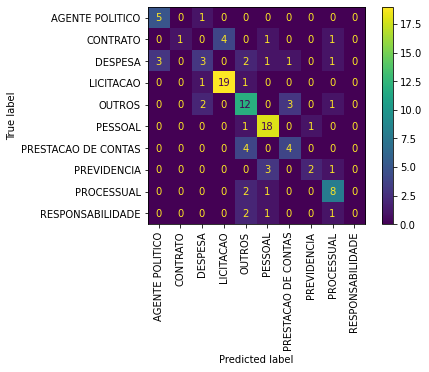

In [67]:
X_train_b, X_test_b, y_train_b, y_test_b = \
    train_test_split(df_model.ementa_limpa, df_model.assunto_agrupado, test_size=0.2, \
                     stratify=df_model.assunto_agrupado, random_state=42, shuffle = True,)
gs_sgd_10_sem_outros_norm = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm, param_sgd)

## Treinar modelo com Regressão logística

In [69]:
pipe_norm_lg = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()), # default hinge. to get proba=log or modified_huber
])
parameters_lg = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    #'clf__max_iter': (10, 50), Não convergiu
    'clf__penalty': ('l2', None),
    'clf__class_weight': (None, 'balanced'),
    'clf__solver': ('newton-cg', 'lbfgs', 'sag', 'saga'),
    'clf__max_iter': (100, 1000)
}

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__class_weight': (None, 'balanced'),
 'clf__max_iter': (100, 1000),
 'clf__penalty': ('l2', None),
 'clf__solver': ('newton-cg', 'lbfgs', 'sag', 'saga'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:  7.4min finished


done in 446.056s

Best score: 0.681
Best parameters set:
	clf__class_weight: 'balanced'
	clf__max_iter: 100
	clf__penalty: 'l2'
	clf__solver: 'newton-cg'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
Score:  0.6696428571428571
F1-Score:  0.6557748134218722


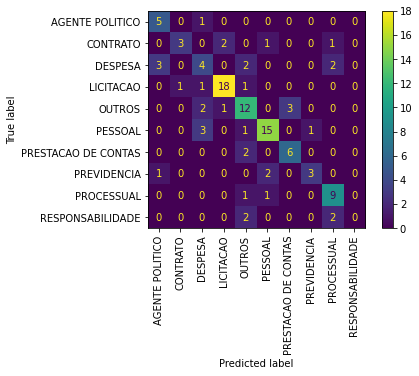

In [70]:
gs_lg_10_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm_lg, parameters_lg)

#### Salvar o modelo para posterior reuso

In [71]:
caminho_model = Path("../../model/")
dump(gs_lg_10_outros.best_estimator_, caminho_model/'modelo_RegLog_9_classes_mais_outros.pkl')

['..\\..\\model\\modelo_RegLog_9_classes_mais_outros.pkl']

## Treinar modelo com Árvore de decisão

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   14.9s finished


done in 15.154s

Best score: 0.498
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
Score:  0.5089285714285714
F1-Score:  0.4866109660267269


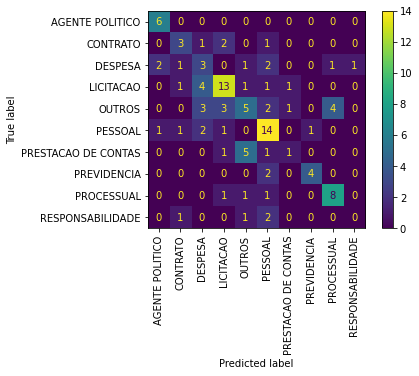

In [72]:
pipe_norm_dt = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=3)), # default hinge. to get proba=log or modified_huber
])

parameters_dt = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    #'clf__max_iter': (10, 50), Não convergiu
    #'clf__criterion': ('gini', 'entropy'),
    #'clf__max_depth': (None, 8),
    #'clf__min_samples_split': (2, 5),
    #'clf__min_samples_leaf': (3, 5),
    #'clf__class_weight': (None, 'balanced')
}

gs_dt_10_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm_dt, parameters_dt)

## Treinar modelo com Radom Forest

In [74]:
pipe_norm_dt = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt, max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf',  RandomForestClassifier(random_state=42, max_features='auto')),
])

parameters_dt = {
    'vect__max_df': (0.75, 1.0),
    #
    #'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    'clf__bootstrap': (True, False),
    'clf__max_depth': (100, None),
    #'clf__max_features': ('auto', 'sqrt'),
    'clf__min_samples_split': (2, 5),
    #'clf__min_samples_leaf': (1, 2, 4),
    #'clf__class_weight': (None, 'balanced')
    'clf__n_estimators': (1400, 2000)
}

gs_rf_10_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm_dt, parameters_dt)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__bootstrap': (True, False),
 'clf__max_depth': (100, None),
 'clf__min_samples_split': (2, 5),
 'clf__n_estimators': (1400, 2000),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 35.1min


KeyboardInterrupt: 

### Ramdom Forest com parâmetros default

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   27.7s finished


done in 28.323s

Best score: 0.602
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
Score:  0.5943396226415094
F1-Score:  0.5613627955470353


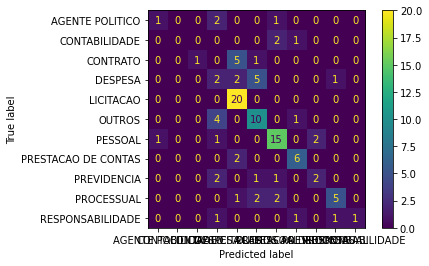

In [65]:
pipe_norm_rf = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt)),
    ('tfidf', TfidfTransformer()),
    ('clf',  RandomForestClassifier(random_state=3)),
])

parameters_rf = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    #'clf__bootstrap': (True, False),
    #'clf__max_depth': (100, None),
    #'clf__max_features': ('auto', 'sqrt'),
    #'clf__min_samples_split': (2, 5https://www.jeltaseminovos.com.br/seminovos/fit-1-5-ex-16v-1188),
    #'clf__min_samples_leaf': (1, 2, 4),
    #'clf__class_weight': (None, 'balanced')
    #'clf__n_estimators': (1400, 2000)
}

gs_rfd_10_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm_rf, parameters_rf)

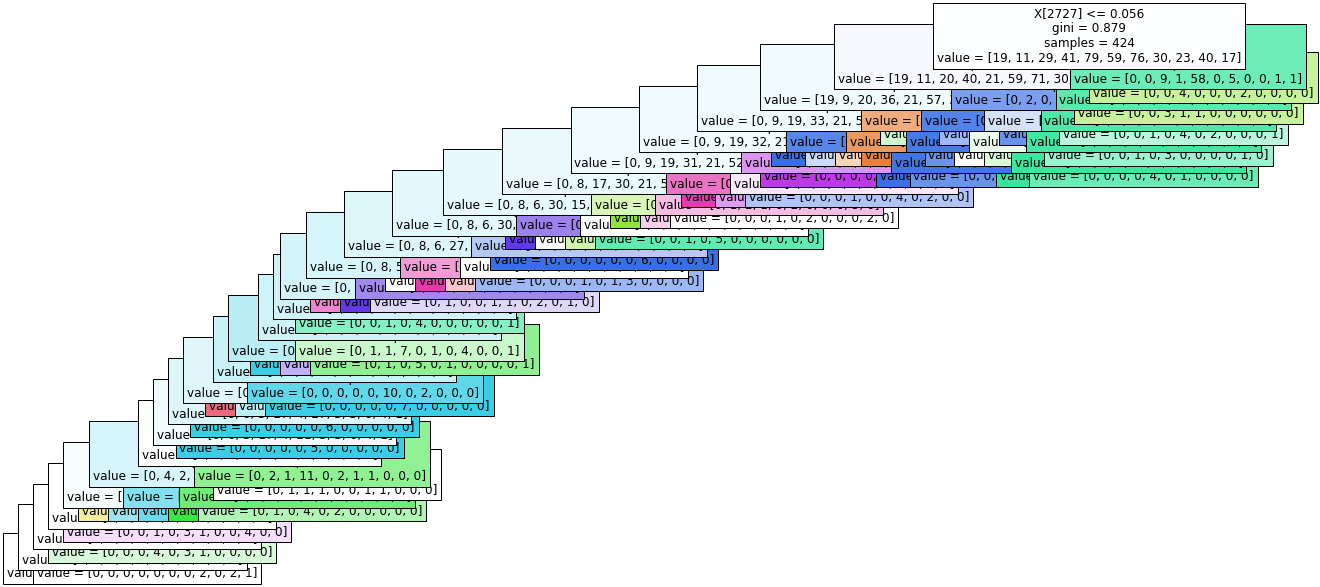

In [94]:
plt.figure(figsize=(20,10))
plot_tree(gs_dt_10_outros.best_estimator_.named_steps['clf'], filled=True, fontsize=12)
#, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

#### Salvar o modelo para posterior reuso

In [95]:
caminho_model = Path("../../model/")
dump(gs_dt_10_outros.best_estimator_, caminho_model/'modelo_DecTre_10_classes_mais_outros.pkl')

['..\\..\\model\\modelo_DecTre_10_classes_mais_outros.pkl']

## Treinar modelo com Naive Bayes

In [58]:
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
le.fit(df_model.assunto_agrupado)
le.classes_

array(['AGENTE POLITICO', 'CONTABILIDADE', 'CONTRATO', 'DESPESA',
       'LICITACAO', 'OUTROS', 'PESSOAL', 'PRESTACAO DE CONTAS',
       'PREVIDENCIA', 'PROCESSUAL', 'RESPONSABILIDADE'], dtype=object)

In [59]:
Y = le.transform(df_model.assunto_agrupado)

In [60]:
pipe_norm_nb = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords_pt)),
    ('tfidf', TfidfTransformer()),
    ('clf', GaussianNB()), 
])

parameters_nb = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #
    #'clf__fit_prior': (False, True),
    #'clf__alpha': (0, 1.0)
}

X_train_b, X_test_b, y_train_b, y_test_b = \
    train_test_split(df_model.ementa_limpa,Y, test_size=0.2, stratify=Y, random_state=42)
gs_nb_10_outros = model_test(X_train_b, X_test_b, y_train_b, y_test_b, pipe_norm_nb, parameters_nb)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.8s finished


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

#### Salvar o modelo para posterior reuso

In [99]:
caminho_model = Path("../../model/")
dump(gs_nb_10_outros.best_estimator_, caminho_model/'modelo_NB_10_classes_mais_outros.pkl')

['..\\..\\model\\modelo_NB_10_classes_mais_outros.pkl']

## Testar desempenho dos modelos com dados de teste
Até o momento, estavam sendo utilizados dados de treino e validação. <br>
Agora o desempenho dos modelos será testado com dados reservados anteriormente para testes

### Analisar dataset de testes

In [100]:
print(df_test.shape)
df_test

(87, 12)


,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
484,Boletim de Jurisprudência TCE-PI - julho 2020 ...,2020-07,Licitação. Irregularidade no termo de referência.,ANÁLISE DE PRESTAÇÃO DE CONTAS. IRREGULARIDADE...,(Prestação de Contas. Processo 7 – Relator: Co...,LICITACAO,acordao,559,2020.0,LICITACAO,1,9
421,Boletim de Jurisprudência TCE-PI - Março - 18....,2018-03,Licitação. Fragmentação de despesas. Aquisição...,PRESTAÇÃO DE CONTAS - FUNDAÇÃO HOSPITALAR DE T...,(Prestação de Contas. Processo – Relatora: Co...,LICITACAO,acordao,343,2018.0,LICITACAO,1,9
418,Boletim de Jurisprudência TCE-PI - Maio - 18.docx,2018-05,Licitação. Suspensão temporária de participaçã...,PRESTAÇÃO DE CONTAS. LICITAÇÃO. CONTRATAÇÃO DE...,(Prestação de Contas. Processo – Relator: Con...,LICITACAO,acordao,237,2018.0,LICITACAO,1,9
460,Boletim de Jurisprudência TCE-PI - Agosto - 18...,2018-08,Licitação. Inexigibilidade. Aprovação de parec...,PRESTAÇÃO DE CONTAS. IMPROPRIEDADES EM PROCEDI...,(Prestação de Contas. Processo – Relator: Con...,LICITACAO,acordao,1206,2018.0,LICITACAO,1,9
469,Boletim de Jurisprudência TCE-PI - Dezembro-18...,2018-12,Licitação. Reincidência de contratos emergenci...,EMENTA. LICITAÇÃO. AUSENCIA DE PLANEJAMENTO NO...,(Prestação de Contas. Processo – Relator: Con...,LICITACAO,acordao,2063,2018.0,LICITACAO,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
31,Boletim de Jurisprudência TCE-PI - Março - 19....,2019-03,Responsabilidade. Responsabilidade do Chefe do...,PEDIDO DE REVISÃO. AUSÊNCIA DE PARCELAMENTO DA...,(Recurso. Processo – Relator Cons. Joaquim Ke...,RESPONSABILIDADE,acordao,401,2019.0,RESPONSABILIDADE,9,1
19,Boletim de Jurisprudência TCE-PI - Abril - 19....,2019-04,Responsabilidade. Gestor não pode ser responsa...,LICITAÇÕES E CONTRATOS. FRAGMENTAÇÃO DE DESPES...,(Prestação de Contas. Processo – Relator Cons...,RESPONSABILIDADE,acordao,541,2019.0,RESPONSABILIDADE,9,1
28,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,1
3,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Contabilidade. Restos a pagar sem comprovação ...,EMENTA. PRESTAÇÃO DE CONTAS. FMS 2ª GESTÃO. AU...,(Prestação de Contas. Processo – Relatora: Co...,CONTABILIDADE,acordao,3149,2017.0,CONTABILIDADE,10,0


### Analisar desempenho dos modelos

In [211]:
X = df_test.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))

In [212]:
caminho_model = Path("../../model/")

In [272]:
def performance_model(model, X_test_t, y_test_t):   
    pred = model.predict(X_test_t)

    #print('Score: ', model.score(X_test_t, y_test_t))
    print("Acurácia: {:.2f}%".format(accuracy_score(pred,y_test_t)*100))
    print('Precisão: {:.2f}%'.format(precision_score(y_test_t, pred, average="weighted", zero_division=1)*100))
    print('Recall  : {:.2f}%'.format(recall_score(y_test_t, pred, average="weighted", zero_division=1)*100))
    print('F1-Score: {:.2f}%'.format(f1_score(y_test_t, model.predict(X_test_t), average="weighted")*100))

In [273]:
print('Performance com SVM - SGD')
performance_model(load(caminho_model/'modelo_SGD_10_classes_mais_outros.pkl'), X, df_test.assunto_agrupado)

Performance com SVM - SGD
Acurácia: 56.32%
Precisão: 61.59%
Recall  : 56.32%
F1-Score: 53.61%


In [274]:
print('Performance com Regressão Logística')
performance_model(load(caminho_model/'modelo_RegLog_10_classes_mais_outros.pkl'), X, df_test.assunto_agrupado)

Performance com Regressão Logística
Acurácia: 66.67%
Precisão: 66.99%
Recall  : 66.67%
F1-Score: 65.90%


In [275]:
print('Performance com Árvore de decisão')
performance_model(load(caminho_model/'modelo_DecTre_10_classes_mais_outros.pkl'), X, df_test.assunto_agrupado)

Performance com Árvore de decisão
Acurácia: 36.78%
Precisão: 39.13%
Recall  : 36.78%
F1-Score: 37.40%


In [276]:
print('Performance com Naive Bayes')
le = preprocessing.LabelEncoder()

performance_model(load(caminho_model/'modelo_NB_10_classes_mais_outros.pkl'), X, le.fit_transform(df_test.assunto_agrupado))

Performance com Naive Bayes
Acurácia: 58.62%
Precisão: 58.42%
Recall  : 58.62%
F1-Score: 52.19%


## Tratar problema de desbalanceamento das classes

### Analisar desempenho de modelo que mais performou

Acurácia 0.6666666666666666
F1-Score:  0.6590469195416723

Relatório de Classificação:
                      precision    recall  f1-score   support

    AGENTE POLITICO     0.6000    1.0000    0.7500         3
      CONTABILIDADE     1.0000    0.5000    0.6667         2
           CONTRATO     0.5000    0.6667    0.5714         6
            DESPESA     0.3333    0.2500    0.2857         8
          LICITACAO     0.7368    0.8235    0.7778        17
             OUTROS     0.6000    0.4615    0.5217        13
            PESSOAL     0.7647    0.8125    0.7879        16
PRESTACAO DE CONTAS     0.5000    0.6667    0.5714         6
        PREVIDENCIA     0.7500    0.6000    0.6667         5
         PROCESSUAL     1.0000    0.8750    0.9333         8
   RESPONSABILIDADE     0.5000    0.3333    0.4000         3

           accuracy                         0.6667        87
          macro avg     0.6623    0.6354    0.6302        87
       weighted avg     0.6699    0.6667    0.6590      

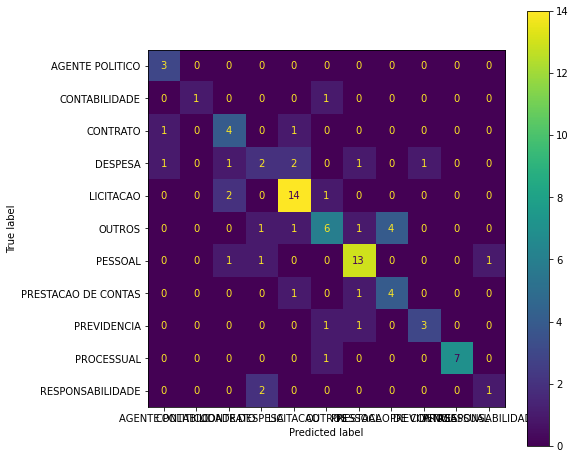

In [228]:
# Carregar modelo mais performático: Regressão Logística
loaded_model = load(caminho_model/'modelo_RegLog_10_classes_mais_outros.pkl')

print('Acurácia %s' % accuracy_score(loaded_model.predict(X), df_test.assunto_agrupado))
print('F1-Score: ', f1_score(df_test.assunto_agrupado, loaded_model.predict(X), average="weighted"))
print("\nRelatório de Classificação:\n", classification_report(df_test.assunto_agrupado, \
                                                             loaded_model.predict(X), digits=4))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(loaded_model, X, df_test.assunto_agrupado, ax=ax)

É possível observar que, apesar de a acurácia ser de 67%, algumas classes apresentam recall e f1-score muito baixos.<br>
Isso justifica o experimento de técnicas para tratar o desbalanceamento das classes.

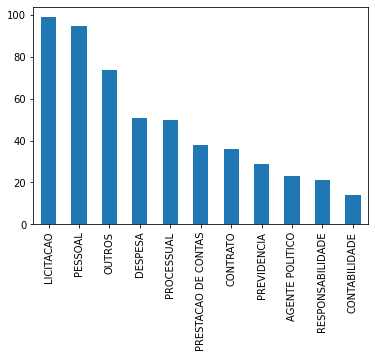

In [134]:
# Confirmar desbalanceamento da frequência
df_model.assunto_agrupado.value_counts().plot(kind='bar')

### Aplicar técnica SMOTE para tratar desbalanceamento

In [191]:
y=le.fit_transform(df_model.assunto_agrupado)
y[:20]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10, 10, 10,
       10, 10, 10])

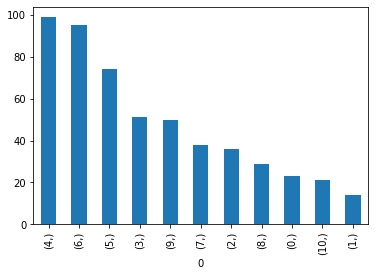

In [192]:
pd.DataFrame(y).value_counts().plot(kind='bar')

In [178]:
loaded_model.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer(max_df=0.75, ngram_range=(1, 2),
                   stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                               'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                               'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                               'ao', 'ele', 'das', 'à', 'seu', 'sua', ...])),
  ('tfidf', TfidfTransformer(use_idf=False)),
  ('clf', LogisticRegression(class_weight='balanced', solver='saga'))],
 'verbose': False,
 'vect': TfidfVectorizer(max_df=0.75, ngram_range=(1, 2),
                 stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                             'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                             'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                             'ao', 'ele', 'das', 'à', 'seu', 'sua', ...]),
 'tfidf': TfidfTransformer(use_idf=False),
 'clf': LogisticRegression(class_weig

In [208]:
tfidf = TfidfVectorizer(stop_words=stopwords_pt)
lg = LogisticRegression(class_weight='balanced', max_iter=100, penalty='l2', solver='saga')

X= tfidf.fit_transform(df_model.ementa_limpa)
y=le.fit_transform(df_model.assunto_agrupado)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train_s, y_train_s = oversample.fit_sample(X_train_s, y_train_s)

lg.fit(X_train_s, y_train_s)
pred_lg = lg.predict(X_test_s)
print('Acurácia %s' % accuracy_score(pred_lg,y_test_s))
print(classification_report(y_test_s,pred_lg))

Acurácia 0.6509433962264151
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.50      0.33      0.40         3
           2       0.80      0.57      0.67         7
           3       0.36      0.40      0.38        10
           4       0.72      0.90      0.80        20
           5       0.47      0.47      0.47        15
           6       0.90      0.95      0.92        19
           7       0.38      0.38      0.38         8
           8       1.00      0.83      0.91         6
           9       0.67      0.60      0.63        10
          10       1.00      0.25      0.40         4

    accuracy                           0.65       106
   macro avg       0.65      0.56      0.58       106
weighted avg       0.67      0.65      0.64       106



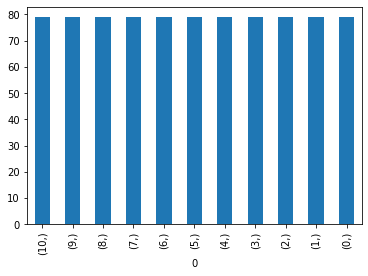

In [209]:
pd.DataFrame(y_train_s).value_counts().plot(kind='bar')

Apesar de o problema do desbalanceamento ter sido sanado, isso não resultou em melhoria de desempenho do modelo, na verdade teve uma pequena piora. Acurácia e f1-score saíram de 67% e 66% para 65% e 64%, respectivamente.